In [1]:
# Import libraries and setup paths
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

from src.data_preproc import load_csv, handle_missing_values, encode_categorical
from src.features import create_work_life_balance_score, create_stress_index
from src.clustering import run_kmeans, evaluate_silhouette
from src.viz import plot_scatter, plot_radar, plot_heatmap
# -------------------------------------------------------
# Load preprocessed / encoded data
# -------------------------------------------------------

df_encoded = pd.read_csv('../data/processed/mental_health_features.csv')


print("Loaded processed data:", df_encoded.shape)
print("First 15 columns:", df_encoded.columns.tolist()[:15])

Loaded processed data: (1433, 82)
First 15 columns: ['are_you_selfemployed', 'how_many_employees_does_your_company_or_organization_have', 'is_your_employer_primarily_a_tech_companyorganization', 'is_your_primary_role_within_your_company_related_to_techit', 'does_your_employer_provide_mental_health_benefits_as_part_of_healthcare_coverage', 'do_you_know_the_options_for_mental_health_care_available_under_your_employerprovided_coverage', 'has_your_employer_ever_formally_discussed_mental_health_for_example_as_part_of_a_wellness_campaign_or_other_official_communication', 'does_your_employer_offer_resources_to_learn_more_about_mental_health_concerns_and_options_for_seeking_help', 'is_your_anonymity_protected_if_you_choose_to_take_advantage_of_mental_health_or_substance_abuse_treatment_resources_provided_by_your_employer', 'if_a_mental_health_issue_prompted_you_to_request_a_medical_leave_from_work_asking_for_that_leave_would_be', 'do_you_think_that_discussing_a_mental_health_disorder_with_your

In [2]:
# Load raw dataset
df = pd.read_csv('../data/raw/mental-heath-in-tech-2016_20161114.csv')

# Data Cleaning
df_clean = handle_missing_values(df, strategy='median')

# Encode categorical/text columns to numeric using one-hot encoding
df_encoded = encode_categorical(df_clean)

In [3]:
# Feature Engineering 
balance_columns = [
    'Does your employer provide mental health benefits as part of healthcare coverage?_Yes',
    'Do you know the options for mental health care available under your employer-provided coverage?_Yes',
    'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?_Yes',
    'Does your employer offer resources to learn more about mental health concerns and options for seeking help?_Yes'
]

df_features = df_encoded.copy()
df_features['work_life_balance_score'] = df_features[balance_columns].mean(axis=1)


print(df_features[['work_life_balance_score']].head())

   work_life_balance_score
0                     0.00
1                     0.75
2                     0.00
3                     0.25
4                     0.50


In [4]:
# 🔹 Clean Data Before Clustering
print("Cleaning data before clustering...")


if 'What is your age?' in df_features.columns:
    before = len(df_features)
    df_features = df_features[(df_features['What is your age?'] > 10) & (df_features['What is your age?'] < 100)]
    after = len(df_features)
    print(f"Removed {before - after} rows with invalid ages.")


df_features = df_features.dropna(thresh=int(df_features.shape[1]*0.5))


df_features = df_features.reset_index(drop=True)

print("Data cleaned successfully!")

Cleaning data before clustering...
Removed 2 rows with invalid ages.
Data cleaned successfully!


In [5]:
# Clustering (K-Means)
# Run K-Means clustering with 4 clusters (can adjust n_clusters)
labels, kmeans_model = run_kmeans(df_features, n_clusters=4)
df_features['Cluster'] = labels

# Evaluate clustering quality using Silhouette Score
score = evaluate_silhouette(df_features.drop('Cluster', axis=1), labels)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.2081619138918122


In [6]:
#  Analyze Clusters
# Count of employees in each cluster
print("Number of employees in each cluster:")
print(df_features['Cluster'].value_counts())

# Mean of features for each cluster
cluster_summary = df_features.groupby('Cluster').mean()
print("\nCluster feature means:")
print(cluster_summary)

Number of employees in each cluster:
Cluster
0    589
1    381
2    370
3     91
Name: count, dtype: int64

Cluster feature means:
         Are you self-employed?  \
Cluster                           
0                      0.190153   
1                      0.244094   
2                      0.116216   
3                      0.428571   

         Is your employer primarily a tech company/organization?  \
Cluster                                                            
0                                                 0.826825         
1                                                 0.795276         
2                                                 0.832432         
3                                                 0.769231         

         Is your primary role within your company related to tech/IT?  \
Cluster                                                                 
0                                                 0.988115              
1                             

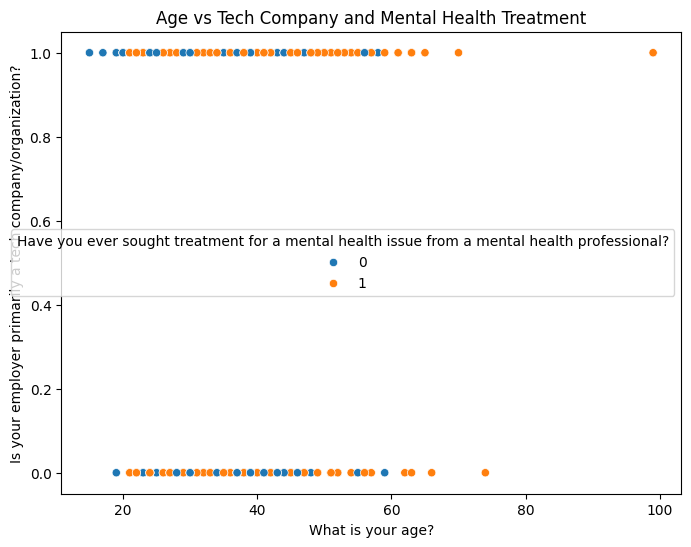

In [ ]:
# Visualization
# Scatter plot 
plot_scatter(df_features, 
             x_col='What is your age?', 
             y_col='Is your employer primarily a tech company/organization?', 
             hue='Have you ever sought treatment for a mental health issue from a mental health professional?', 
             title='Age vs Tech Company and Mental Health Treatment')


plot_heatmap(df_features, title='Feature Correlation Heatmap')


plot_radar(df_features, 
           features=['What is your age?', 
                     'Do you have previous employers?', 
                     'Have you ever sought treatment for a mental health issue from a mental health professional?'], 
           group_col='Is your employer primarily a tech company/organization?')

In [ ]:
import pandas as pd
import os
from sklearn.cluster import KMeans

# 1)Check if df_features exists
if 'df_features' not in locals():
    print("df_features does not exist, reloading from file")
    df_features = pd.read_csv('../data/processed/mental_health_features.csv')
else:
    print("df_features already exists")

# 2)Select only numeric columns and fill NaN
numeric_cols = df_features.select_dtypes(include=['int64', 'float64']).columns
numeric_data = df_features[numeric_cols].fillna(df_features[numeric_cols].median())

# 3)Create 'Cluster' column if it does not exist
if 'Cluster' not in df_features.columns:
    print("'Cluster' column does not exist, creating it automatically")
    kmeans = KMeans(n_clusters=4, random_state=42)
    labels = kmeans.fit_predict(numeric_data)
    df_features['Cluster'] = labels
    print("'Cluster' column added successfully")
else:
    print("'Cluster' column already exists")

# 4)Save CSV
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../reports', exist_ok=True)
df_features.to_csv('../data/processed/mental_health_features.csv', index=False)
print("CSV file saved successfully at ../data/processed/mental_health_features.csv")

# 5)Create Cluster Profiles report
with open('../reports/cluster_profiles.md', 'w', encoding='utf-8') as f:
    for cluster_id in df_features['Cluster'].unique():
        f.write(f"# Cluster {cluster_id}\n")
        f.write(f"Number of employees: {df_features[df_features['Cluster'] == cluster_id].shape[0]}\n\n")
        f.write("Average feature values:\n")
        cluster_means = df_features[df_features['Cluster'] == cluster_id].mean(numeric_only=True)
        f.write(cluster_means.to_string())
        f.write("\n\n")

print("Clustering analysis complete! Report saved at ../reports/cluster_profiles.md")

In [1]:
# Safe reload for saving
import pandas as pd
print("Checking df_features:", 'df_features' in locals())
if 'df_features' not in locals():
    print("df_features disappeared, reloading from file")
    df_features = pd.read_csv('../data/processed/mental_health_features.csv')
    print("df_features reloaded successfully")

Checking df_features: False
df_features disappeared, reloading from file
df_features reloaded successfully


In [2]:
import pandas as pd
import os
from sklearn.cluster import KMeans

# 1)Check if df_features exists in memory
if 'df_features' not in locals():
    print("df_features does not exist, reloading from file")
    df_features = pd.read_csv('../data/processed/mental_health_features.csv')
else:
    print("df_features already exists")

# 2)Select only numeric columns
numeric_cols = df_features.select_dtypes(include=['int64', 'float64']).columns
numeric_data = df_features[numeric_cols].fillna(df_features[numeric_cols].median())

# 3)Check if 'Cluster' column exists
if 'Cluster' not in df_features.columns:
    print("'Cluster' column does not exist, creating it automatically")
    kmeans = KMeans(n_clusters=4, random_state=42)
    labels = kmeans.fit_predict(numeric_data)
    df_features['Cluster'] = labels
    print("'Cluster' column added successfully")
else:
    print("'Cluster' column already exists")

# 4)Save results safely
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../reports', exist_ok=True)
df_features.to_csv('../data/processed/mental_health_features.csv', index=False)
print("CSV file saved successfully at ../data/processed/mental_health_features.csv")

# 5)Create Cluster Profiles report for HR
with open('../reports/cluster_profiles.md', 'w', encoding='utf-8') as f:
    for cluster_id in df_features['Cluster'].unique():
        f.write(f"# Cluster {cluster_id}\n")
        f.write(f"Number of employees: {df_features[df_features['Cluster'] == cluster_id].shape[0]}\n\n")
        f.write("Average feature values:\n")
        cluster_means = df_features[df_features['Cluster'] == cluster_id].mean(numeric_only=True)
        f.write(cluster_means.to_string())
        f.write("\n\n")

print("Clustering analysis complete! Report saved at ../reports/cluster_profiles.md")

df_features already exists
'Cluster' column already exists
CSV file saved successfully at ../data/processed/mental_health_features.csv
Clustering analysis complete! Report saved at ../reports/cluster_profiles.md
